In [249]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [250]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}




In [251]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [252]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
# W (input , out = n_Neuron)
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)  #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [253]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

  # forward pass
  emb = C[Xb]  # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Yb).to()
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:  # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
plt.plot(lossi)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

下面是改进版本

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

C = C.to(device)
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

In [ ]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)
# BatchNorm parameters
bngain = bngain.to(device)
bnbias = bnbias.to(device)
bnmean_running = bnmean_running.to(device)
bnstd_running = bnstd_running.to(device)


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]  # (32, 3, 10)
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1 + b1
  # BatchNorm layer
  # -------------------------------------------------------------
  # torch.nn.BatchNorm1d   0.001 == momentum 如果你的batch_size 太小 导致前后两次随机性太大 momentum 建议小点
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  # 仅初始时， 希望是高斯分布  训练时，是希望分布改变，包括 平移（bnbias） 高矮胖瘦 （bngain）
  # bngain  bnbias 作为超参数  每个神经元 都有
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2  # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())
  # track stats
  if i % 10000 == 0:  # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



In [ ]:



# hpreact.shape

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')





In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else self.bias)


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)  # 为什么是1 而不是 0

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)  # batch mean
      xvar = x.var(0, keepdim=True)  # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var#%%
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}




In [ ]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

In [ ]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
# W (input , out = n_Neuron)
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)  #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

  # forward pass
  emb = C[Xb]  # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
  logits = h @ W2 + b2  # (32, 27)
  loss = F.cross_entropy(logits, Yb).to()
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:  # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

In [ ]:
plt.plot(lossi)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

下面是改进版本

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

C = C.to(device)
Xtr, Ytr = Xtr.to(device), Ytr.to(device)
Xdev, Ydev = Xdev.to(device), Ydev.to(device)
Xte, Yte = Xte.to(device), Yte.to(device)

In [ ]:
# 字符总数    embedimg layer  : input : vocab_size   out : n_embd
vocab_size = len(itos)
n_embd = 10

# 隐藏层神经元的个数
n_hidden = 200
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)
# BatchNorm parameters
bngain = bngain.to(device)
bnbias = bnbias.to(device)
bnmean_running = bnmean_running.to(device)
bnstd_running = bnstd_running.to(device)


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]  # (32, 3, 10)
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1 + b1
  # BatchNorm layer
  # -------------------------------------------------------------
  # torch.nn.BatchNorm1d   0.001 == momentum 如果你的batch_size 太小 导致前后两次随机性太大 momentum 建议小点
  bnmeani = hpreact.mean(dim=0, keepdim=True)
  bnstdi = hpreact.std(dim=0, keepdim=True)
  # 仅初始时， 希望是高斯分布  训练时，是希望分布改变，包括 平移（bnbias） 高矮胖瘦 （bngain）
  # bngain  bnbias 作为超参数  每个神经元 都有
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2  # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())
  # track stats
  if i % 10000 == 0:  # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



In [ ]:



# hpreact.shape

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')





In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

In [ ]:
# SUMMARY + PYTORCHIFYING -----------

#  增加 BatchNorm1d layer  即使不 调整    fan_in ** 0.5  与   gain   也能 得到比较高的训练性能

In [337]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.zeros(dim)  # 为什么是1 而不是 0

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True)  # batch mean
      xvar = x.var(0, keepdim=True)  # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [338]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)


layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  layers[-1].gamma *= 0.1  # last layer: make less confident
  # layers[-1].weight *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3 #3 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [339]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  # 串联的好处
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  # 是因为自定义?
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


各层输出分布
gain < 5/3 时    层 std 下降很快 不能稳定在1附近 ; saturated 很小
gain > 5/3 时    层 std 稳定在1附近            ;但saturated 很大

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

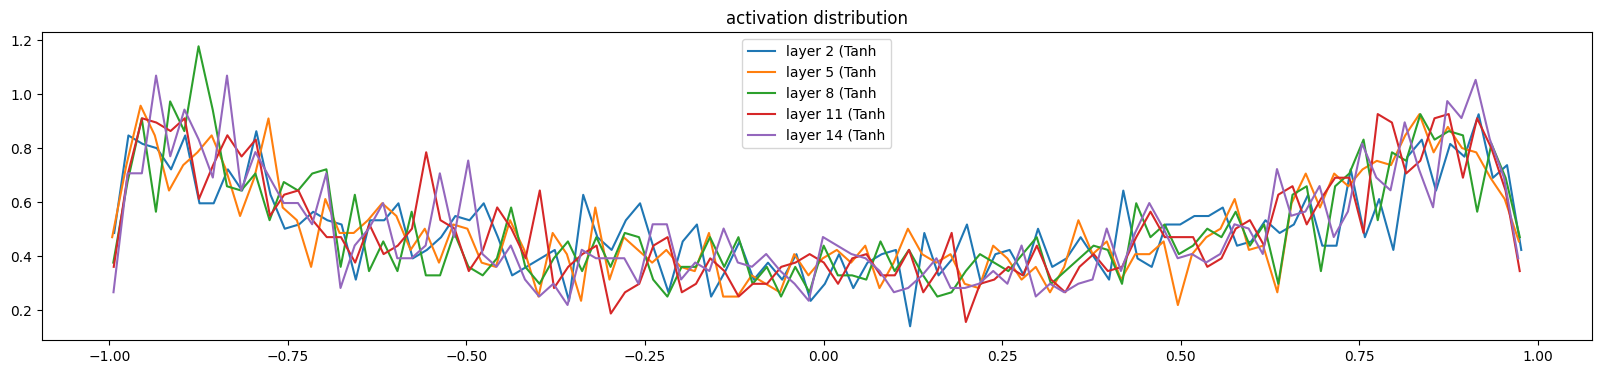

In [340]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out  # [32, 100]
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().  mean()*100))
    hy, hx = torch.histogram(t, density=True)   # z直接将 32 * 100 一起统计
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

 各层 反向传播的梯度

layer 2 (      Tanh): mean -0.000000, std 3.682958e-03
layer 5 (      Tanh): mean -0.000000, std 3.262611e-03
layer 8 (      Tanh): mean -0.000000, std 2.973733e-03
layer 11 (      Tanh): mean -0.000000, std 2.741113e-03
layer 14 (      Tanh): mean -0.000000, std 2.584295e-03


Text(0.5, 1.0, 'gradient distribution')

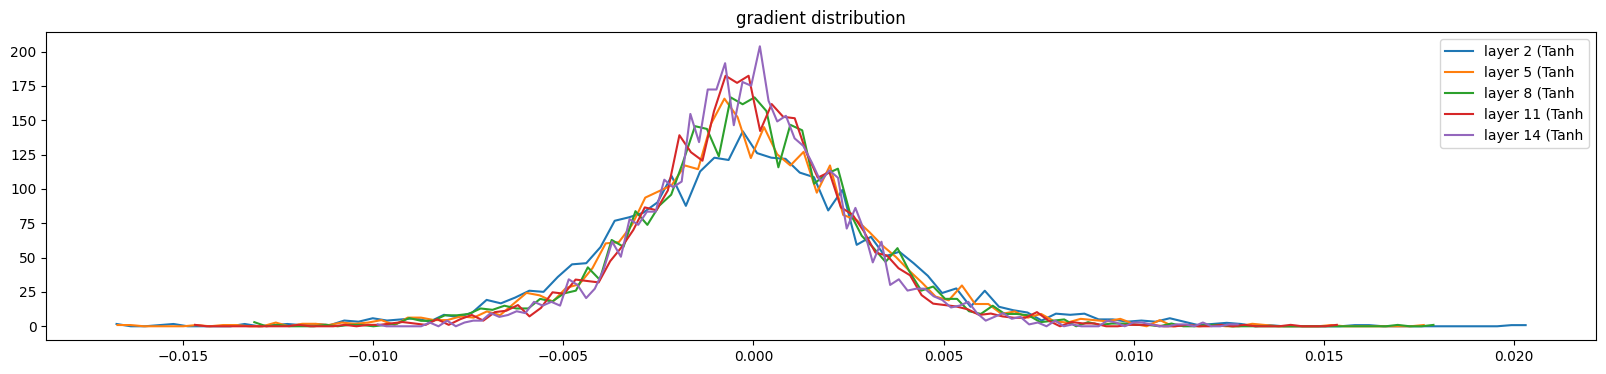

In [342]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

各层 参数梯度 分布

weight   (27, 10) | mean -0.000000 | std 1.019888e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238439e-03 | grad:data ratio 2.635842e-02
weight (100, 100) | mean +0.000031 | std 7.318120e-03 | grad:data ratio 4.377149e-02
weight (100, 100) | mean -0.000019 | std 6.662029e-03 | grad:data ratio 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821520e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445302e-03 | grad:data ratio 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281271e-02


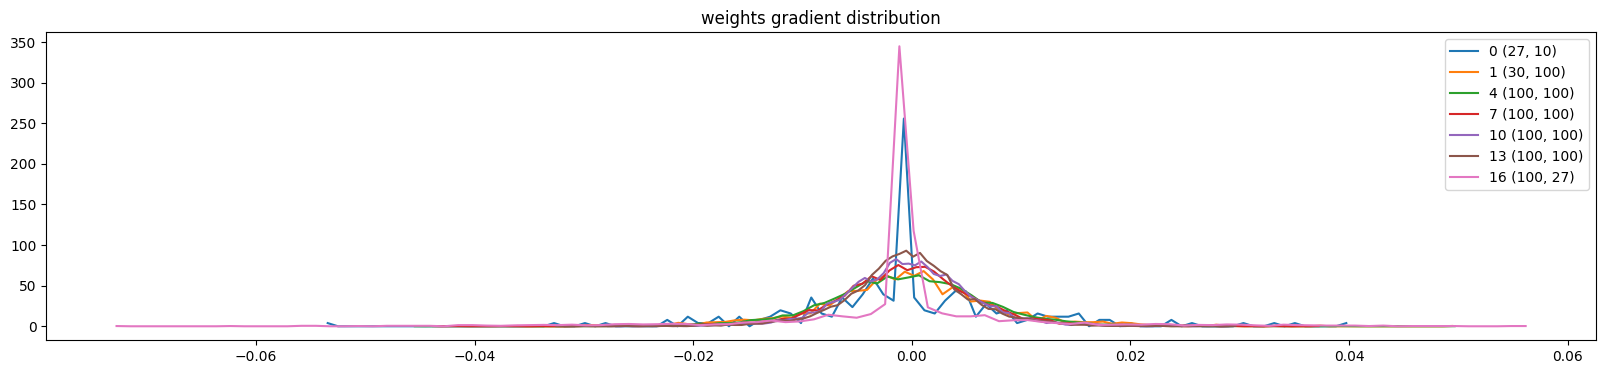

In [343]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

参数更新率    ((lr*p.grad).std() / p.data.std()).log10()
 r < 1e-3  说明学习率低了
 r > 1e-3  说明学习率过高

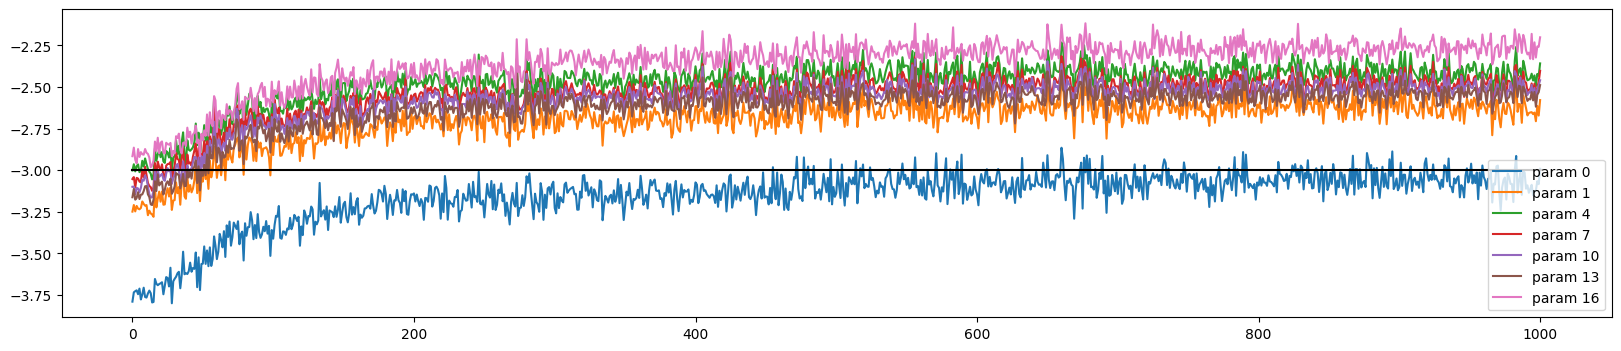

In [344]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [345]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.434417963027954
val 2.4324371814727783


In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
# DONE; BONUS content below, not covered in video

In [346]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

In [347]:
def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [384]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [387]:
g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())


inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


 理解

In [ ]:
# loss = -probs[torch.arange(num),ys].log().mean()  其实就是 预测下个值是ys的概率   mean 多个样本
# 假设没有先验信息, 下个值是ys的概率 应该是 1/27         多个样本的平均也是 1/27
# loss = -1/27.log()  == 3.2958
loss = -torch.tensor(1 / 27.0).log()  #

In [ ]:
# 而我们通过正态分布 得到的 loss = 25  显然是初始权重W b 设置不合理   导致前面的多次训练 其实没有优化
# 初始时:
#   1. logits = h @ W2 + b2    给出的分布差异过大   正态
#     (1) b2 随机导致的   b2 = 0
#     (2) 正态分布 不够矮胖(平均)  矮胖化   W2 = W2*0.01
#     (3) logits 为什么不能是平均即  W2 = b2 = 0

#   2. emb @ W1  两个标准高斯分布的乘积 仍是高斯分布,均值仍为0  但方差增加(高瘦)  使 W1 矮胖(1/sqrt(n_in) )   b1 = 0
#      确保 emb @ W1 + b1 也是一个标准高斯分布
#      h = torch.tanh(emb @ W1 + b1)     标准高斯分布 经过 tanh(非线性)  两边值强制为0;
#      为了 确保 h 也类似一个标准高斯分布后    W1 需要
#      本质 emb @ W1 + b1 是正态分布 均值是 b   太矮胖  我们需要 均值是0, 大多数值 在 (-1 1) 的高瘦的正态分布
#
#     (32)

In [ ]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0);
loss = -probs[2].log()
logits, probs, loss

In [ ]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

 理解

In [74]:
# loss = -probs[torch.arange(num),ys].log().mean()  其实就是 预测下个值是ys的概率   mean 多个样本
# 假设没有先验信息, 下个值是ys的概率 应该是 1/27         多个样本的平均也是 1/27
# loss = -1/27.log()  == 3.2958
loss = -torch.tensor(1 / 27.0).log()  #

tensor(3.2958)

In [ ]:
# 而我们通过正态分布 得到的 loss = 25  显然是初始权重W b 设置不合理   导致前面的多次训练 其实没有优化
# 初始时:
#   1. logits = h @ W2 + b2    给出的分布差异过大   正态
#     (1) b2 随机导致的   b2 = 0
#     (2) 正态分布 不够矮胖(平均)  矮胖化   W2 = W2*0.01
#     (3) logits 为什么不能是平均即  W2 = b2 = 0

#   2. emb @ W1  两个标准高斯分布的乘积 仍是高斯分布,均值仍为0  但方差增加(高瘦)  使 W1 矮胖(1/sqrt(n_in) )   b1 = 0
#      确保 emb @ W1 + b1 也是一个标准高斯分布
#      h = torch.tanh(emb @ W1 + b1)     标准高斯分布 经过 tanh(非线性)  两边值强制为0;
#      为了 确保 h 也类似一个标准高斯分布后    W1 需要
#      本质 emb @ W1 + b1 是正态分布 均值是 b   太矮胖  我们需要 均值是0, 大多数值 在 (-1 1) 的高瘦的正态分布
#
#     (32)

In [80]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0);
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.7382, -0.8575, -1.3519, -0.8741]),
 tensor([0.3029, 0.2688, 0.1640, 0.2644]),
 tensor(1.8082))

train 2.3349530696868896
val 2.3489842414855957


In [15]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [201]:
ll = torch.randint(0,11,(3,10)).float()

# 计算直方图，设置为概率密度
values, bins = torch.histogram(ll, density=True)
values,bins


(tensor([1.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6667,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.6667]),
 tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,  0.7000,
         

In [202]:
ll

tensor([[ 4., 10.,  2.,  9.,  3.,  0.,  4.,  9.,  6.,  8.],
        [ 3.,  0., 10.,  8.,  1.,  2.,  9.,  3.,  2.,  3.],
        [ 9.,  4.,  6.,  0.,  7.,  2.,  0.,  2.,  6.,  5.]])

In [203]:
values.shape,bins.shape

(torch.Size([100]), torch.Size([101]))

In [209]:
4/30

0.13333333333333333

In [205]:
value  = torch.histc(ll)
value,value.shape

(tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         4., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 torch.Size([100]))

In [260]:
torch.histogram(torch.tensor([1., 2, 1,1]), bins=4, range=(0., 3.))
torch.histogram(torch.tensor([1., 2, 1, 1]), bins=4, range=(0., 3.), density=True)



torch.return_types.histogram(
hist=tensor([0.0000, 1.0000, 0.3333, 0.0000]),
bin_edges=tensor([0.0000, 0.7500, 1.5000, 2.2500, 3.0000]))

In [262]:
xx = torch.randn((1,10))
yy = torch.randn((10,100))
zz = xx @ yy

1.0000499999999999